In [1]:
import importlib
import os

from keras.layers import Input, Embedding, GRU, GRUCell, Bidirectional, TimeDistributed, Dense, Lambda
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
import keras.backend as K
from keras.utils import plot_model

import numpy as np
import random

from utils.write import training_data, test_data, collapse_documents, expand_answers, _read_data, glove, START_TOKEN, END_TOKEN, look_up_token

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# run params
SECTION = 'write'
RUN_ID = '0001'
DATA_NAME = 'qa'
RUN_FOLDER = '../run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

# data

In [3]:
#### LOAD DATA ####

test_data_gen = test_data()
batch = next(test_data_gen)
batch = collapse_documents(batch)

# parameters

In [4]:
VOCAB_SIZE = glove.shape[0]
EMBEDDING_DIMENS = glove.shape[1]

GRU_UNITS = 100
MAX_DOC_SIZE = None
MAX_ANSWER_SIZE = None
MAX_Q_SIZE = None

# architecture

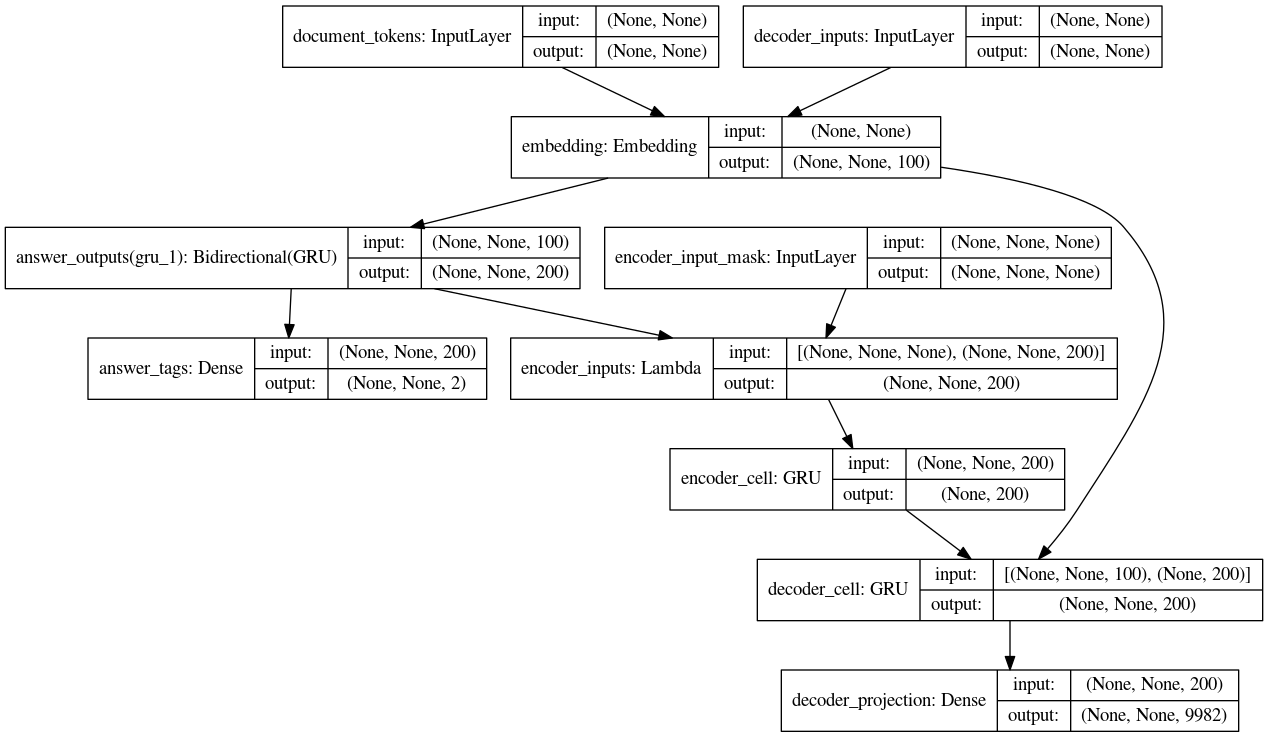

In [5]:
#### TRAINING MODEL ####

document_tokens = Input(shape=(MAX_DOC_SIZE,), name="document_tokens")

embedding = Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_DIMENS, weights=[glove], mask_zero = True, name = 'embedding')
document_emb = embedding(document_tokens)

answer_outputs = Bidirectional(GRU(GRU_UNITS, return_sequences=True), name = 'answer_outputs')(document_emb)
answer_tags = Dense(2, activation = 'softmax', name = 'answer_tags')(answer_outputs)

encoder_input_mask = Input(shape=(MAX_ANSWER_SIZE, MAX_DOC_SIZE), name="encoder_input_mask")
encoder_inputs = Lambda(lambda x: K.batch_dot(x[0], x[1]), name="encoder_inputs")([encoder_input_mask, answer_outputs])
encoder_cell = GRU(2 * GRU_UNITS, name = 'encoder_cell')(encoder_inputs)

decoder_inputs = Input(shape=(MAX_Q_SIZE,), name="decoder_inputs")
decoder_emb = embedding(decoder_inputs)
decoder_emb.trainable = False
decoder_cell = GRU(2 * GRU_UNITS, return_sequences = True, name = 'decoder_cell')
decoder_states = decoder_cell(decoder_emb, initial_state = [encoder_cell])

decoder_projection = Dense(VOCAB_SIZE, name = 'decoder_projection', activation = 'softmax', use_bias = False)
decoder_outputs = decoder_projection(decoder_states)

total_model = Model([document_tokens, decoder_inputs, encoder_input_mask], [answer_tags, decoder_outputs])
plot_model(total_model, to_file='model.png',show_shapes=True)

In [6]:
#### INFERENCE MODEL ####

decoder_inputs_dynamic = Input(shape=(1,), name="decoder_inputs_dynamic")
decoder_emb_dynamic = embedding(decoder_inputs_dynamic)
decoder_init_state_dynamic = Input(shape=(2 * GRU_UNITS,), name = 'decoder_init_state_dynamic') #the embedding of the previous word
decoder_states_dynamic = decoder_cell(decoder_emb_dynamic, initial_state = [decoder_init_state_dynamic])
decoder_outputs_dynamic = decoder_projection(decoder_states_dynamic)

answer_model = Model(document_tokens, [answer_tags])
decoder_initial_state_model = Model([document_tokens, encoder_input_mask], [encoder_cell])
question_model = Model([decoder_inputs_dynamic, decoder_init_state_dynamic], [decoder_outputs_dynamic, decoder_states_dynamic])



In [10]:
### LOAD MODEL WEIGHTS ####

model_num = 677

total_model.load_weights(os.path.join(RUN_FOLDER, 'weights/weights_{}.h5'.format(model_num)), by_name = True)
question_model.load_weights(os.path.join(RUN_FOLDER, 'weights/weights_{}.h5'.format(model_num)), by_name = True)
answer_model.load_weights(os.path.join(RUN_FOLDER, 'weights/weights_{}.h5'.format(model_num)), by_name = True)
decoder_initial_state_model.load_weights(os.path.join(RUN_FOLDER, 'weights/weights_{}.h5'.format(model_num)), by_name = True)



# testing

Predicted answer probabilities


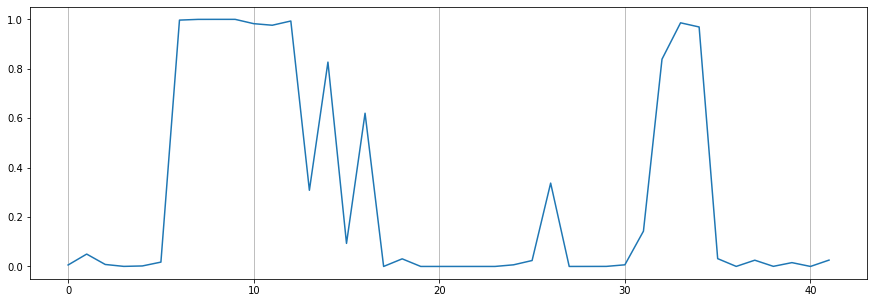

0 the 0.01
1 winning 0.05
2 goal 0.01
3 was 0.0
4 scored 0.0
5 by 0.02
6 23-year-old 1.0
7 striker 1.0
8 joe 1.0
9 bloggs 1.0
10 during 0.98
11 the 0.98
12 match 0.99
13 between 0.31
14 arsenal 0.83
15 and 0.09
16 barcelona 0.62
17 . 0.0
18 arsenal 0.03
19 recently 0.0
20 signed 0.0
21 the 0.0
22 striker 0.0
23 for 0.0
24 50 0.01
25 million 0.02
26 pounds 0.34
27 . 0.0
28 the 0.0
29 next 0.0
30 match 0.01
31 is 0.14
32 in 0.84
33 two 0.99
34 weeks 0.97
35 time, 0.03
36 on 0.0
37 july 0.03
38 31st 0.0
39 2005 0.02
40 . 0.0
41  0.03


In [11]:
# answer placement predictions

plt.figure(figsize=(15,5))
idx = 0

answer_preds = answer_model.predict(batch["document_tokens"])

print('Predicted answer probabilities')
ax = plt.gca()
ax.xaxis.grid(True)
plt.plot(answer_preds[idx, :, 1])
plt.show()

for i in range(len(batch['document_words'][idx])):
    print(i, batch['document_words'][idx][i], np.round(answer_preds[idx][i][1],2))

In [12]:
# set chosen answer position

start_answer = 37
end_answer = 39

print(batch['document_words'][idx][start_answer:(1+end_answer)])

['july', '31st', '2005']


In [13]:

answer_preds = answer_model.predict(batch["document_tokens"])

answers = [[0] * len(answer_preds[idx])]
for i in range(start_answer, end_answer + 1):
    answers[0][i] = 1

answer_batch = expand_answers(batch, answers)

next_decoder_init_state = decoder_initial_state_model.predict([answer_batch['document_tokens'][[idx]], answer_batch['answer_masks'][[idx]]])

word_tokens = [START_TOKEN]
questions = [look_up_token(START_TOKEN)]

ended = False
counter = 0

while not ended:
    
    counter += 1

    word_preds, next_decoder_init_state = question_model.predict([word_tokens, next_decoder_init_state])

    next_decoder_init_state = np.squeeze(next_decoder_init_state, axis = 1)
    word_tokens = np.argmax(word_preds, 2)[0]

    questions.append(look_up_token(word_tokens[0]))

    if word_tokens[0] == END_TOKEN or counter > 20 :
        ended = True

questions = ' '.join(questions)

In [14]:
questions

'<START> when does the first 3 <UNK> take place ? <END>'